## Introduction
In this notebook WRN-50-2 model is created and trained on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not. Model is trained through different experiments:
1. Adam optimizer and without any data augmentation
2. With Augmentation and Adam optimizer
3. Pretrained model with Adam optimizer and Data augmentation.

Model is evaluated for performance metrics on test data. Finally model is incorporated with Score-CAM interpretability technique.

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Optional: If processed.zip is downloaded from google drive link
Unzip the pre processed dataset zip file, located in google drive at https://drive.google.com/file/d/1pjMCimi8fs1W0ccrwF4nkP0vKUYG_szR/view?usp=sharing

In [ ]:
!unzip -u "/content/drive/MyDrive/processed.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed/train/1/7cf4a9ef-0192-432d-bcf4-b4f8ebb3704a.npy  
  inflating: /content/processed/train/1/7d1b94bf-9fb6-4191-bf69-09549b4a3b96.npy  
  inflating: /content/processed/train/1/7d3b3dd0-2fa5-43dc-a84b-673bc0eebaa7.npy  
  inflating: /content/processed/train/1/7d3f2d28-c21b-4a64-940c-c635176f35e1.npy  
  inflating: /content/processed/train/1/7d402380-193a-4aef-92aa-8c80e11217fb.npy  
  inflating: /content/processed/train/1/7d5f828f-5c6a-4898-a64f-8364339f35cd.npy  
  inflating: /content/processed/train/1/7d674c82-5501-4730-92c5-d241fd6911e7.npy  
  inflating: /content/processed/train/1/7d6b6af5-80ec-48c7-8efd-c11183e16280.npy  
  inflating: /content/processed/train/1/7d80378b-b46b-4dbc-a8b5-70982536ea06.npy  
  inflating: /content/processed/train/1/7d93788d-2fb5-41f1-ba86-477681241879.npy  
  inflating: /content/processed/train/1/7d9de861-2aa8-49d6-a2c5-47a5d7e1d06f.npy  
  inflating: /content/processed/trai

In [ ]:
# Install the torchmetrics
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Install pytorch-lightning wrapper
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 18.2 MB/s eta 0:00:00


In [ ]:
# install torcheval
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.9 MB/s eta 0:00:00


In [ ]:
# install scikit-plot
!pip install scikit-plot

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for handling matrices and associated operations
* matplotlib for visualizing some images



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
from torchmetrics.classification import BinaryAccuracy
from torcheval.metrics.aggregation.auc import AUC
import torchmetrics
import pytorch_lightning as pl
from torch.utils.data import Dataset
from pytorch_lightning.callbacks import ModelCheckpoint


import math
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn

from tqdm.notebook import trange, tqdm


Checking the library versions

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import matplotlib
print(torch.__version__)
print(matplotlib.__version__)
print(torchvision.__version__)
print(sn.__version__)
print(np.__version__)
print(pd.__version__)

2.3.1+cu121
3.7.1
0.18.1+cu121
0.13.1
1.25.2
2.0.3


Define the train, validation, and test dataset paths to the directory created after the executing the "Data_Collection_And_Preprocessing.ipynb"

If processed.zip file is downloaded and used, then provide path to test, train and val directories created after unzipping that file.

In [ ]:
train_dataset_path = "/content/processed/train/"
val_dataset_path = "/content/processed/val/"
test_dataset_path = "/content/processed/test/"

checkpoint_path = "/content/drive/MyDrive/wrn-50-2_checkpoints"
model_save_path = "/content/drive/MyDrive/wrn-50-2.wt"

Setting up the important parameters for the model and trainer

In [ ]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 60
# Optimizer learning rate
learning_rate = 0.001

weight_decay = 1e-4

num_workers = 4# TODO


In [ ]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our unzipped numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).



Define the load_file function

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

## Experiment 1: Without Augmentation

In first experiment, transforms are created without any data augmentation applied.

In [ ]:
# train_transforms = transforms.Compose([
#                                     transforms.ToTensor(),  # Convert numpy array to tensor
#                                     transforms.Resize((224, 224)),
#                                     transforms.Normalize(0.49, 0.248)  # Use mean and std from preprocessing notebook
# ])


# val_transforms = transforms.Compose([
#                                     transforms.ToTensor(),  # Convert numpy array to tensor
#                                     transforms.Resize((224, 224)),
#                                     transforms.Normalize([0.49], [0.248])  # Use mean and std from preprocessing notebook
# ])

# test_transforms = transforms.Compose([
#                                     transforms.ToTensor(), # Convert numpy array to tensor
#                                     transforms.Resize((224, 224)),
#                                     transforms.Normalize([0.49], [0.248])  # Use mean and std from preprocessing notebook
# ])

## Experiment 2:  With Data Augmentation

In experiment 2, data tranforms are created for train, validatin and test sets are created. Data augmentation is only applied to test transform with following settings:

* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [ ]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                    transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.35, 1.33))

])


val_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Convert numpy array to tensor
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize([0.49], [0.248])  # Use mean and std from preprocessing notebook
])

test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Convert numpy array to tensor
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize([0.49], [0.248])  # Use mean and std from preprocessing notebook
])




Finally, train, validation, and test dataset is created with corresponding transforms.

In [ ]:

train_dataset = torchvision.datasets.DatasetFolder(
    train_dataset_path,
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    val_dataset_path,
    loader=load_file, extensions="npy", transform=val_transforms)

test_dataset = torchvision.datasets.DatasetFolder(
    test_dataset_path,
    loader=load_file, extensions="npy", transform=test_transforms)


In [ ]:
# print the number of train images, test images and validation images.
print(f"There are {len(train_dataset)} train images,  {len(test_dataset)} test images and {len(val_dataset)} val images")

There are 19200 train images,  4800 test images and 2684 val images


Inpects some random chest X-ray images from train dataset

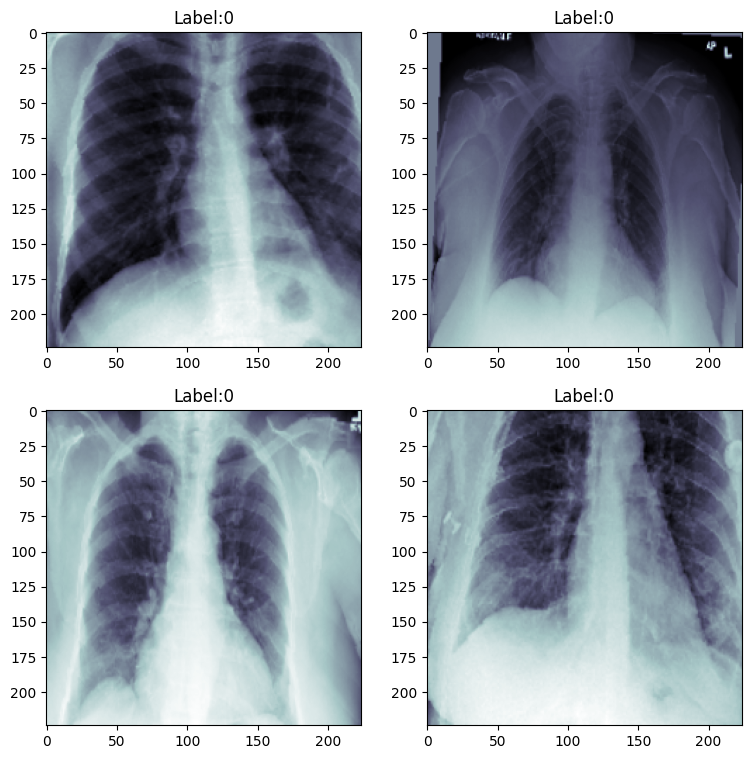

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")


Inspect validation images

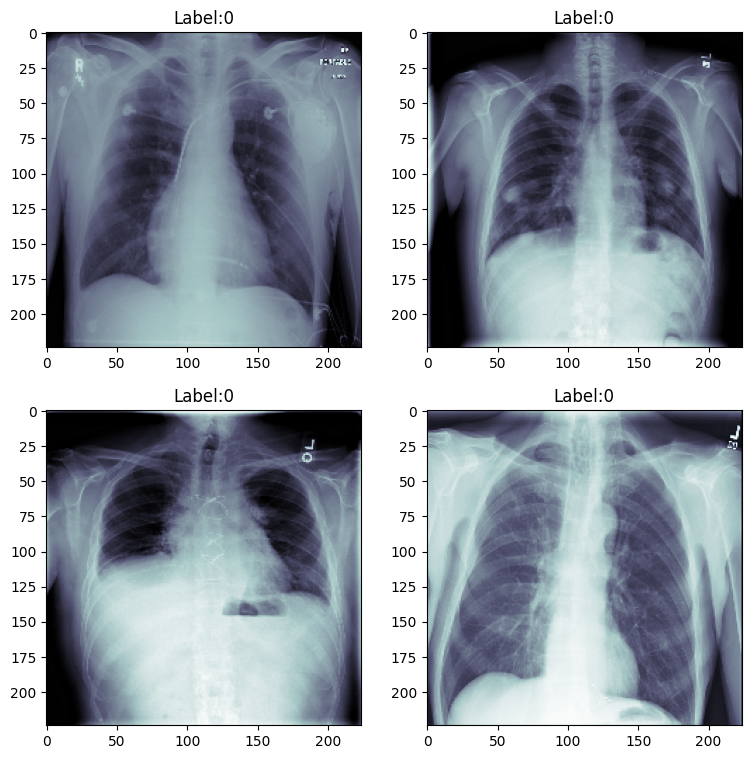

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = val_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Inspect test images

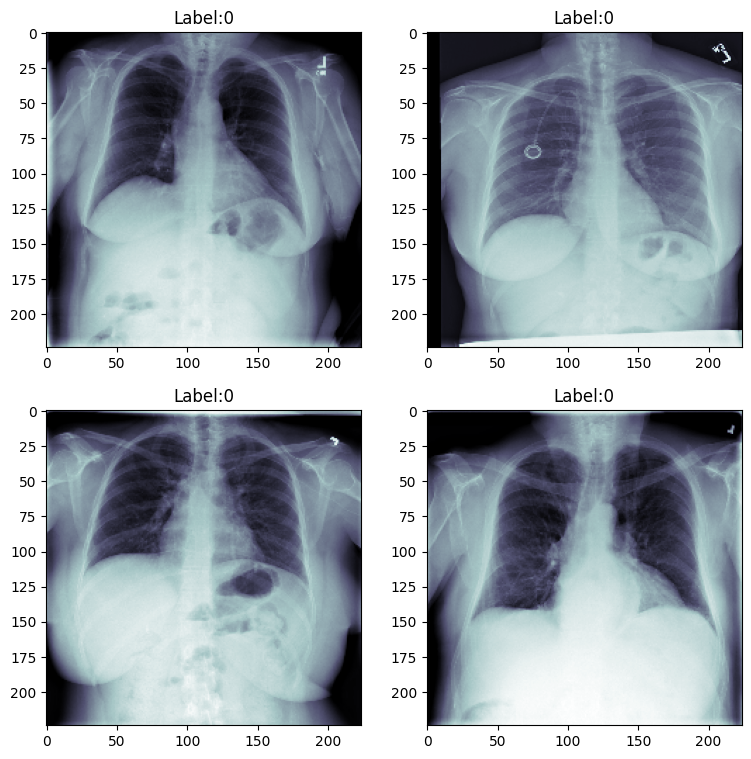

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = test_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Create train, validation and test loader using train, validation and test dataset.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing

For this research, weighted loss is adopted.
In train dataset, non-pneumonia images are three time the pneumonia images. Therefore weight loss that is used in the research is 3.

In [ ]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([14452,  4748])), (array([0, 1]), array([2079,  605])))

## WRN-50-2 Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, **on_train_epoch_end** callback is used to compute overall dataset statistics and metrics such as accuracy and loss.

Subsequently, **validation_step** is defined. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, **on_validation_epoch_end** can be used to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Model Creation** - WRN-50-2 (Wide_resnet50_2) network architecture is used.

As most of the torchvision models, the original WRN-50-2 expects a three channel input in **conv1**. <br />
However, the X-Ray image data has only one channel. Thus, the in_channel parameter needs to be changed from 3 to 1.

Additionally, the last fully connected layer will be changed to have only one output since there is a binary class label.

### Optimizer and Loss
The **Adam optimizer** is used with a learning rate of 0.001 and the BinaryCrossEntropy loss function.<br />
(In fact, **BCEWithLogitsLoss** is used, which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy.).



In [ ]:
class WideResNet50_2(pl.LightningModule):
    def __init__(self, weight=3.0):
        super(WideResNet50_2, self).__init__()
        #For PRETRAINED MODEL:  set the pretrained to True else false
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()

        self.training_avg_acc_logger = []
        self.training_avg_loss_logger = []
        self.training_acc_logger = []
        self.training_loss_logger = []

        self.validation_avg_acc_logger = []



    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.training_loss_logger.append(loss.item())
        self.train_acc(torch.sigmoid(pred), label.int())
        return loss

    def on_train_epoch_end(self):
        # After one epoch compute the whole train_data accuracy
        self.training_avg_loss_logger.append(sum(self.training_loss_logger)/len(self.training_loss_logger))
        self.training_avg_acc_logger.append(self.train_acc.compute().item())

        print("Train Acc", self.train_acc.compute().item())
        print("Train Loss:", sum(self.training_loss_logger)/len(self.training_loss_logger))
        self.train_acc.reset()
        self.training_loss_logger = []

    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape
        self.val_acc(torch.sigmoid(pred), label.int())

    def on_validation_epoch_end(self):
        print("Val Acc",self.val_acc.compute())
        self.validation_avg_acc_logger.append(self.val_acc.compute().item())
        self.val_acc.reset()


    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one )
        return [self.optimizer]

In [ ]:
# Instanciate the model
model50_2 = WideResNet50_2(weight=3.0)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 173MB/s]


Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

Create Model checkpoint callback to save the model after every 10 epochs

In [ ]:
every_n_epochs = 10
checkpoint_callback = ModelCheckpoint(
        # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
        filename="wrn-50-2-2_classifier_{epoch:02d}",
        every_n_epochs=every_n_epochs,
        save_top_k=-1,  # <--- this is important!
    )

Create the trainer using model checkpoint

In [ ]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    default_root_dir=checkpoint_path,
    max_epochs=num_epochs)
print(num_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


60


In [ ]:
# Fit / Train the model using train loader and val loader
trainer.fit(model50_2, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 66.8 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
66.8 M    Trainable params
0         Non-trainable params
66.8 M    Total params
267.320   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val Acc tensor(0.4609, device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7977, device='cuda:0')
Train Acc 0.6432812213897705
Train Loss: 0.9143324412902196


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7120, device='cuda:0')
Train Acc 0.7166146039962769
Train Loss: 0.8080048157771429


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7157, device='cuda:0')
Train Acc 0.7304166555404663
Train Loss: 0.7996903892358144


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7131, device='cuda:0')
Train Acc 0.7370833158493042
Train Loss: 0.7814464129010836


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8186, device='cuda:0')
Train Acc 0.7457291483879089
Train Loss: 0.770182088315487


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7858, device='cuda:0')
Train Acc 0.7514062523841858
Train Loss: 0.7551453971862793


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7899, device='cuda:0')
Train Acc 0.7510416507720947
Train Loss: 0.7573971291383107


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7515, device='cuda:0')
Train Acc 0.7530208230018616
Train Loss: 0.7493556853135427


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.5082, device='cuda:0')
Train Acc 0.7515624761581421
Train Loss: 0.748591705362002


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7887, device='cuda:0')
Train Acc 0.75390625
Train Loss: 0.7420339774092038


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7615, device='cuda:0')
Train Acc 0.7506771087646484
Train Loss: 0.743629275560379


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6822, device='cuda:0')
Train Acc 0.75760418176651
Train Loss: 0.7359201770027478


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6725, device='cuda:0')
Train Acc 0.7579687237739563
Train Loss: 0.7304855139056842


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7910, device='cuda:0')
Train Acc 0.7597395777702332
Train Loss: 0.7263306873043378


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7656, device='cuda:0')
Train Acc 0.7601562738418579
Train Loss: 0.7288132113218307


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6718, device='cuda:0')
Train Acc 0.761145830154419
Train Loss: 0.7231915066639583


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7791, device='cuda:0')
Train Acc 0.7593749761581421
Train Loss: 0.7227709369858106


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8245, device='cuda:0')
Train Acc 0.7616145610809326
Train Loss: 0.7171189778049787


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8256, device='cuda:0')
Train Acc 0.7596874833106995
Train Loss: 0.7196824209888776


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7794, device='cuda:0')
Train Acc 0.76171875
Train Loss: 0.711835282544295


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7563, device='cuda:0')
Train Acc 0.7640104293823242
Train Loss: 0.7118551923831304


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7254, device='cuda:0')
Train Acc 0.7672916650772095
Train Loss: 0.7081222288807233


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8048, device='cuda:0')
Train Acc 0.7592187523841858
Train Loss: 0.7093456248442332


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8007, device='cuda:0')
Train Acc 0.7613541483879089
Train Loss: 0.7067111248771349


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6352, device='cuda:0')
Train Acc 0.7685937285423279
Train Loss: 0.6988458344340325


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8096, device='cuda:0')
Train Acc 0.7659375071525574
Train Loss: 0.7012344317634901


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7761, device='cuda:0')
Train Acc 0.7676562666893005
Train Loss: 0.6996006285150845


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7824, device='cuda:0')
Train Acc 0.7679166793823242
Train Loss: 0.6955472656091054


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8193, device='cuda:0')
Train Acc 0.7647395730018616
Train Loss: 0.69393169850111


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7858, device='cuda:0')
Train Acc 0.7620312571525574
Train Loss: 0.6983425680796306


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7843, device='cuda:0')
Train Acc 0.7625520825386047
Train Loss: 0.6924240025877952


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6803, device='cuda:0')
Train Acc 0.7681770920753479
Train Loss: 0.6964922328790029


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7198, device='cuda:0')
Train Acc 0.7699479460716248
Train Loss: 0.6918923124670983


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7299, device='cuda:0')
Train Acc 0.7708333134651184
Train Loss: 0.6868781503041586


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7966, device='cuda:0')
Train Acc 0.7694270610809326
Train Loss: 0.6902585216363271


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7861, device='cuda:0')
Train Acc 0.7678124904632568
Train Loss: 0.6913975753386815


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7996, device='cuda:0')
Train Acc 0.7669791579246521
Train Loss: 0.6918774000803629


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7664, device='cuda:0')
Train Acc 0.7731249928474426
Train Loss: 0.6912443874279658


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7869, device='cuda:0')
Train Acc 0.7686979174613953
Train Loss: 0.6852937829494476


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7951, device='cuda:0')
Train Acc 0.7689062356948853
Train Loss: 0.683172902961572


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7679, device='cuda:0')
Train Acc 0.7723437547683716
Train Loss: 0.6812274018923442


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6468, device='cuda:0')
Train Acc 0.7743750214576721
Train Loss: 0.6826713808377584


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8007, device='cuda:0')
Train Acc 0.7716666460037231
Train Loss: 0.681958552201589


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8212, device='cuda:0')
Train Acc 0.7698958516120911
Train Loss: 0.6829929498831431


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7385, device='cuda:0')
Train Acc 0.774010419845581
Train Loss: 0.6785780592759451


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8156, device='cuda:0')
Train Acc 0.7698958516120911
Train Loss: 0.6821009280284246


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7500, device='cuda:0')
Train Acc 0.7722916603088379
Train Loss: 0.6790477458635966


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8349, device='cuda:0')
Train Acc 0.7749479413032532
Train Loss: 0.677489516735077


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7835, device='cuda:0')
Train Acc 0.7755728960037231
Train Loss: 0.6702724446853002


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7634, device='cuda:0')
Train Acc 0.7721874713897705
Train Loss: 0.6758875437577565


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8018, device='cuda:0')
Train Acc 0.7745833396911621
Train Loss: 0.6785426597793897


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.6662, device='cuda:0')
Train Acc 0.7717187404632568
Train Loss: 0.6697219957907995


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7470, device='cuda:0')
Train Acc 0.7771875262260437
Train Loss: 0.6674152133862178


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7932, device='cuda:0')
Train Acc 0.7768229246139526
Train Loss: 0.6709651757280032


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8051, device='cuda:0')
Train Acc 0.7751562595367432
Train Loss: 0.6686102631688118


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7738, device='cuda:0')
Train Acc 0.7737500071525574
Train Loss: 0.6684637199838956


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7832, device='cuda:0')
Train Acc 0.7759895920753479
Train Loss: 0.6682023525238037


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7660, device='cuda:0')
Train Acc 0.7794271111488342
Train Loss: 0.6632826428612073


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7955, device='cuda:0')
Train Acc 0.7756770849227905
Train Loss: 0.6705211450656255


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7951, device='cuda:0')
Train Acc 0.77322918176651
Train Loss: 0.6718503073851267


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Save the trained model

In [ ]:
torch.save(model50_2, model_save_path )

## Evaluation

Put the model to evaluation and move it to the device


In [ ]:
model50_2.eval()
model50_2.to(device);

Text(0.5, 1.0, 'WideResNet 50-2 Training Loss')

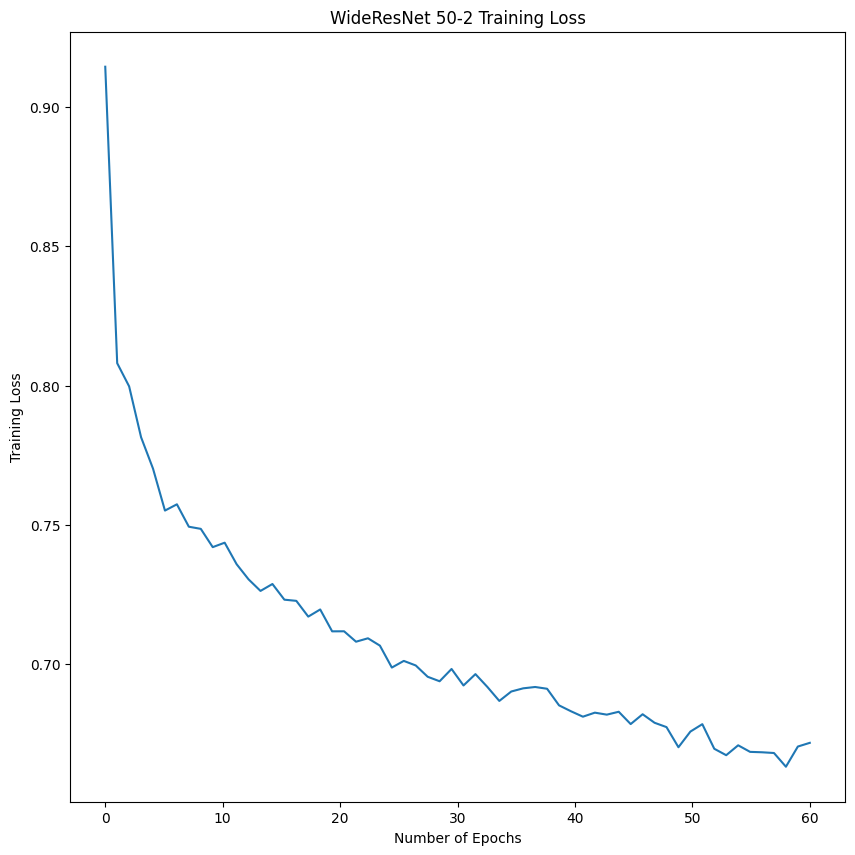

In [ ]:
#Plot the graph for Training loss over the epochs
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model50_2.training_avg_loss_logger))
plt.plot(train_x, model50_2.cpu().training_avg_loss_logger)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title("WideResNet 50-2 Training Loss")

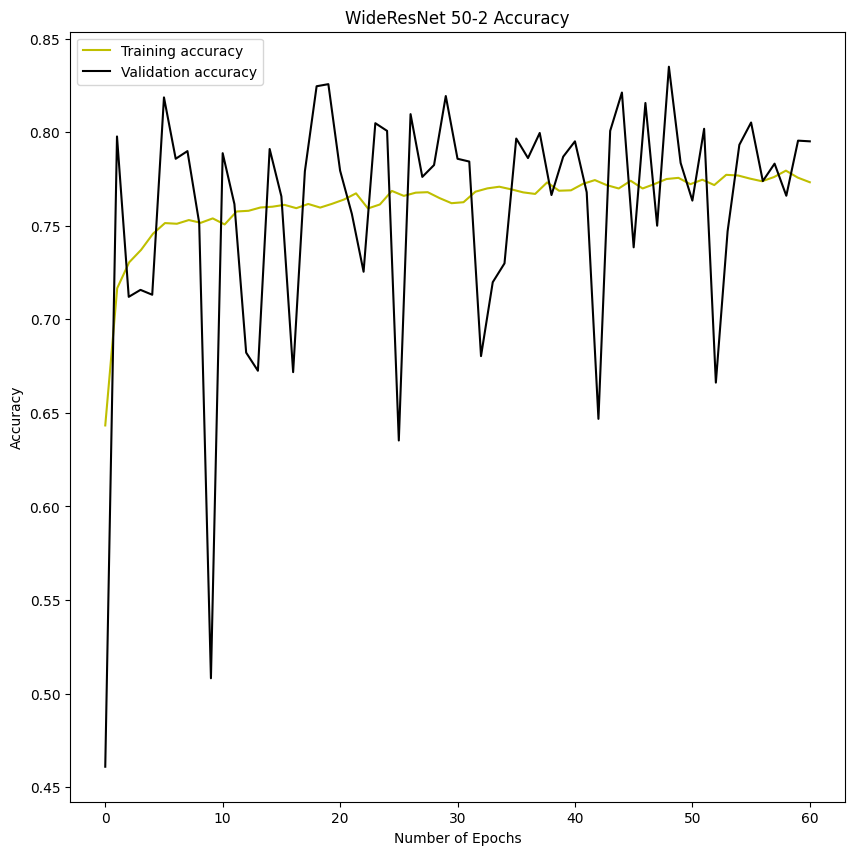

In [ ]:
#Plot the graph for Tranining and validation accuracy over number of epochs
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model50_2.training_avg_acc_logger))
plt.plot(train_x, model50_2.training_avg_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model50_2.validation_avg_acc_logger))
plt.plot(valid_x, model50_2.validation_avg_acc_logger, c = "k")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title("WideResNet 50-2 Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])

Compute prediction on the complete test set and store predictions and labels

In [ ]:
preds = []
labels = []
model50_2.to(device);
with torch.no_grad():
    for data, label in tqdm(test_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model50_2(data).cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/4800 [00:00<?, ?it/s]

Print the performance metrics for test data

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
all_labels = np.array(labels)
all_preds = np.array(preds)
auc_score = roc_auc_score(all_labels, all_preds)
acc = BinaryAccuracy()( preds, labels)
precision = torchmetrics.Precision(task='binary')( preds, labels)
recall = torchmetrics.Recall(task='binary')( preds, labels)
f1 = torchmetrics.F1Score(task='binary')( preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc_score}")
print(f"Confusion Matrix: {cm}")

Accuracy: 0.746874988079071
Precision: 0.3368544578552246
Recall: 0.8710166811943054
F1 Score: 0.4858230948448181
AUC: 0.8792181079760887
Confusion Matrix: tensor([[3011, 1130],
        [  85,  574]])


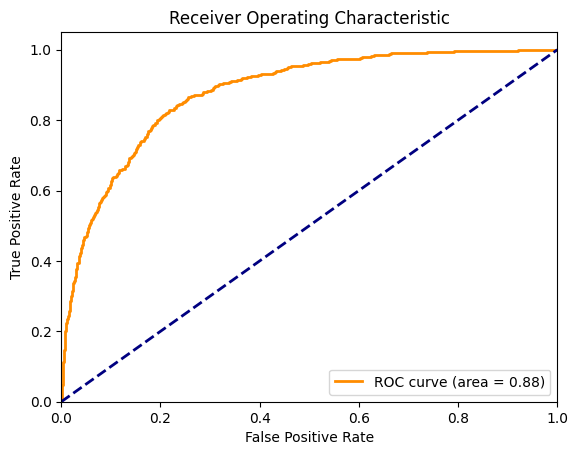

In [ ]:
# Plot the AUC-ROC curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
all_labels = np.array(labels)
all_preds = np.array(preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

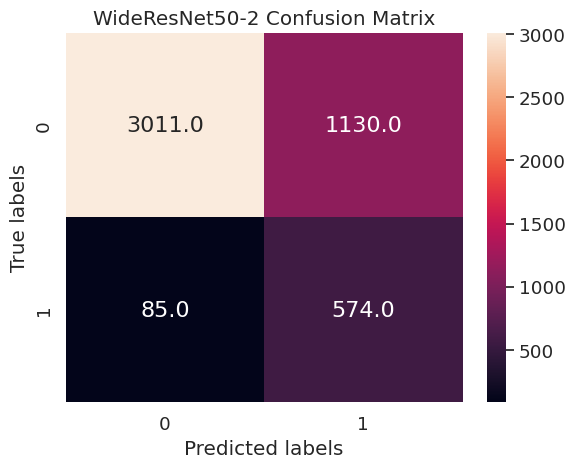

In [ ]:
# Plot the confusion matrix
df_cm = pd.DataFrame(cm.numpy(), range(2), range(2))

sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True,fmt=".1f", annot_kws={"size": 16}) # font size

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('WideResNet50-2 Confusion Matrix')

plt.show()

# Model Interpretability

Defining a class for Score-CAM interpretability.

In [ ]:
# define class for Score-CAM
"""
PyTorch implementation of Score-CAM.
"""

# Import standard libraries.
import copy

# Import third-party packages.
import numpy as np
import torch


class ScoreCAM:
    """
    PyTorch implementation of Score-CAM [1].

    References:
        [1] H. Wang, Z. Wang, M. Du, F. Yang, Z. Zhang, S. Ding, P. Mardziel, and X. Hu,
            "Score-CAM: Score-weighted visual explanations for convolutional neural networks",
            CVPR, 2020.
    """
    def __init__(self, model, actmap, device="cpu"):
        """
        Constructor.

        Args:
            model  (torch.nn.Module): Target NN model.
            actmap (str)            : Name of layer to extract activation maps.
            device (str)            : Device name ("cpu" or "cuda").
        """
        # Copy the target NN model and prepare it.
        self.model = copy.deepcopy(model.to("cpu"))
        self.model.to(device)
        self.model.eval()

        # Register a hook function to extract activation maps.
        getattr(self.model, actmap).register_forward_hook(self.hook)

    def hook(self, module, x_in, x_out):
        """
        Hook function to extract activation maps.
        This function is assumed to be registered to NN layer.

        Args:
            module (torch.nn.Module): Target layer.
            x_in   (torch.Tensor)   : Input tensor of the layer.
            x_out  (torch.Tensor)   : Output tensor of the layer.
        """
        self.activation_map = x_out.detach().to("cpu")

    def compute(self, X, coi, batch_size=128, cskip=False, cskip_out=16):
        """
        Compute visual explanation.

        Args:
            X          (np.ndarray or torch.Tensor): Input image.
            coi        (int or Callable)           : Class of interest.
            batch_size (int)                       : Batch size.
            cskip      (bool)                      : Enable CSKIP optimization.
            cskip_out  (int)                       : Output channels of the CSKIP.

        Returns:
            (torch.Tensor): 2D array of visual explanation.
        """
        # Define a scoring function.
        if isinstance(coi, int):
            self.scoring_fn = lambda output: output[:, coi]
        elif hasattr(coi, "__call__"):
            self.scoring_fn = coi

        # Verify the data type of the input array.
        if (type(X) != np.ndarray) and (type(X) != torch.Tensor):
            raise TypeError("input array should be NumPy or PyTorch array.")

        # Get device.
        device = next(self.model.parameters()).device

        # Convert the input tensor to torch.Tensor on CPU.
        X = torch.Tensor(X).to("cpu")
        X = X.unsqueeze(0)
        # Reshape the input tensor to (B, C, H, W).
        # X, (B, C, H, W) = reshape_input_tensor(X)
        X, (B,C,H,W) = X, X.shape
        print(X.shape, B, C, H, W)

        # Run inference and get activation maps. The activation maps are
        # acquired by the hook function registered in the __init__ function.
        with torch.no_grad():
            p = self.model(X.to(device))

        # Get the reference score.
        s_ref = self.scoring_fn(p.to("cpu"))

        # Apply CSKIP if specified.
        if cskip: A = channel_skipping(self.activation_map, cskip_out)
        else    : A = self.activation_map

        # Get the channel number of the activation maps.
        # Note that the activation maps are always on CPU.
        K = A.shape[1]

        # Upsample the activation maps and change the dimension order
        # from [1, K, H, W] to [K, 1, H, W].
        A = torch.nn.functional.interpolate(A, (H, W), mode="bicubic")
        A = torch.permute(A, [1, 0, 2, 3])

        # Normalize the activation maps.
        self.A_normalized = normalize_activation_map(A)

        # Compute the masked images.
        self.M = X * self.A_normalized

        # Initialize the list of predictions.
        batch_p = list()

        for batch_idx_bgn in range(0, K, batch_size):

            # Get input batch.
            M_batch = self.M[batch_idx_bgn:batch_idx_bgn+batch_size, :, :, :]

            # Run inference to get the predictions.
            with torch.no_grad():
                p = self.model(M_batch.to(device))

            # Add predictions to the list.
            batch_p.append(p.to("cpu"))

        p = torch.concat(batch_p, dim=0)
        A = A.to("cpu")
        X = X.to("cpu")

        # Compute the CIC score for the activation maps.
        s = self.scoring_fn(p) - s_ref
        a = torch.nn.functional.softmax(s, dim=0)
        a = a.reshape([-1, 1, 1])

        # The tensor A should have the shape [C, 1, H, W] at this moment.
        # Change the shape to [C, H, W] for the following summation.
        A = torch.squeeze(A, dim=1)

        # Compute the visual explanation.
        L = torch.nn.functional.relu(torch.sum(a * A.reshape([K, H, W]), dim=0))

        # Returns as NumPy array.
        return L.numpy()

    @staticmethod
    def to_colormap(X, normalize=True):
        """
        Convert input 2D array to a color heat map.

        Args:
            X         (np.ndarray): Input array.
            normalize (bool)      : Normalize the input array if True.

        Returns:
            (np.ndarray): Color heat map.
        """
        # Normalize if specified.
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
            X = np.clip(255 * X, 0, 255).astype(np.uint8)

        # Create JET color map.
        CMAP = np.zeros([256, 3], dtype=np.uint8)
        for i in range(256):
            if   i <  32: j = i -   0; CMAP[i, :] = (      0,       0, 127+4*j)
            elif i <  96: j = i -  32; CMAP[i, :] = (      0,     4*j,     255)
            elif i < 160: j = i -  96; CMAP[i, :] = (    4*j,     255, 255-4*j)
            elif i < 224: j = i - 160; CMAP[i, :] = (    255, 255-4*j,       0)
            else        : j = i - 224; CMAP[i, :] = (255-4*j,       0,       0)

        # Apply the JET color map.
        Y = np.stack([CMAP[X, 0], CMAP[X, 1], CMAP[X, 2]], axis=2)

        return Y

    @staticmethod
    def overlay(image, L):
        """
        Overlay the given visual explanation to the given image.

        Args:
            image (np.ndarray or torch.Tensor): Input image with shape (H, W, C).
            L     (np.ndarray or torch.Tensor): Visual explanation with shape (H, W).

        Returns:
            (np.ndarray): Overlay image with shape (H, W, C).
        """
        # Convert the image and the visual explanation to NumPy array.
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        if isinstance(L, torch.Tensor):
            L = L.numpy()

        M = ScoreCAM.to_colormap(L)
        return np.clip(0.5 * image + 0.5 * M, 0, 255).astype(np.uint8)


def reshape_input_tensor(X):
    """
    Reshape input tensor to shape (B, C, H, W) where B is always 1.

    Args:
        X (torch.Tensor): Input array.

    Returns:
        (tuple): A tuple of (reshaped array, shape of the array).
    """
    # Case 1: X.shape == (H, W)
    if len(X.shape) == 2:

        # Get array shape.
        H, W = X.shape

        # Reshape to (B, C, H, W).
        X = X.reshape((1, 1, H, W))

        return (X, (1, 1, H, W))

    # Case 2: X.shape == (H, W, C)
    elif len(X.shape) == 3:

        # Get array shape.
        H, W, C = X.shape

        # Reshape to (B, C, H, W).
        X = torch.permute(X, [2, 0, 1])
        X = X.reshape((1, C, H, W))

        return (X, (1, C, H, W))

    # Case 3: X.shape == (1, C, H, W)
    elif len(X.shape) == 4:

        # Verify the batch size is one.
        if X.shape[0] != 1:
            raise ValueError("Batch size should be 1")

        return (X, X.shape)

    else:
        raise ValueError("Unexpected input shape: %s" % str(X.shape))


def normalize_activation_map(A, eps=1.0E-10):
    """
    Normalize the given activation map.

    Args:
        A   (np.ndarray): Activation map with shape (K, 1, H, W).
        eps (float)     : Small value to prevent zero division.

    Returns:
        (np.ndarray): Normalized activation map.
    """
    # Compute min/max of each channel.
    A_min, _ = torch.min(torch.flatten(A, start_dim=2), dim=2)
    A_max, _ = torch.max(torch.flatten(A, start_dim=2), dim=2)

    # Reshape the min/max array to the shape (K, 1, 1, 1).
    A_min = A_min.reshape([-1, 1, 1, 1])
    A_max = A_max.reshape([-1, 1, 1, 1])

    # Normalize the activation map.
    return (A - A_min) / (A_max - A_min + eps)


def channel_skipping(A, cskip_out=16):
    """
    CSKIP optimization.

    Args:
        A         (torch.Tensor): Activation maps.
        cskip_out (int)         : Number of output channels.
    """
    # Compute max value of each channel.
    A_max, _ = torch.max(torch.flatten(A, start_dim=2), dim=2)

    # Sort channels by the max value.
    idx_max = torch.argsort(A_max.reshape([-1]), descending=True)

    return A[:, idx_max[:cskip_out], :, :]

Load the saved model

In [ ]:
# model50_2 = torch.load(model_save_path)
# print(model50_2)
# model50_2.eval()

WideResNet50_2(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

WideResNet50_2(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

Create scoreCAM instance by providing the internal model (not the wrapper object)

In [ ]:
scorecam = ScoreCAM(model50_2.model, actmap="layer4", device="cuda")

In [ ]:
# load the numpy image of positive case of pneumonia.
# img = np.load("/content/00436515-870c-4b36-a041-de91049b9ab4.npy")
# img = torch.from_numpy(img).float().unsqueeze(0)
# print(img.shape)

torch.Size([1, 224, 224])


In [ ]:
# load the numpy image of positive case of pneumonia from validation dataset.
img = val_dataset[-6][0]
print(img.shape)

In [ ]:
L = scorecam.compute(img, coi=0)
print(L.shape)

torch.Size([1, 1, 224, 224]) 1 1 224 224
(224, 224)


In [ ]:
# reshape the from (1 x 224 x 224) to (224 x 224 x 1)
cv2_image = img.reshape(224,224,1)
print(cv2_image.shape)

torch.Size([224, 224, 1])


In [ ]:
# predict the image using the trained model
img_input = img.unsqueeze(0)
pred = torch.sigmoid(model50_2(img_input))
print(pred)

tensor([[1.0000]], grad_fn=<SigmoidBackward0>)


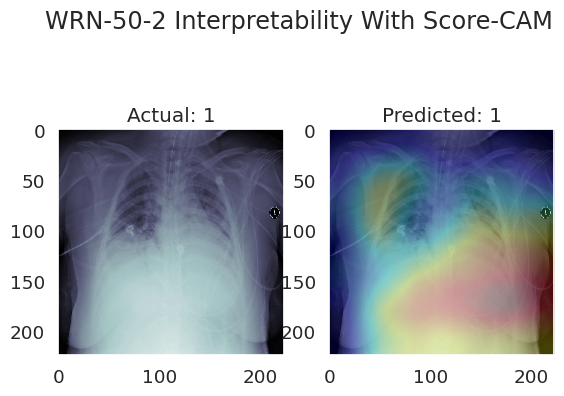

In [ ]:
# Create the overlay heatmap for the target image
image_overlay = scorecam.overlay(cv2_image, L)
# plot the image with the generated scoreCAM overlay
fig, axis = plt.subplots(1,2)
fig.suptitle('WRN-50-2 Interpretability With Score-CAM')
axis[0].imshow(cv2_image, cmap="bone")
axis[0].set_title("Actual: 1")
axis[0].xaxis.grid(False, which='major')
axis[0].yaxis.grid(False, which='major')

axis[1].imshow(cv2_image, cmap="bone")
axis[1].imshow(image_overlay, alpha=0.5, cmap="jet")
axis[1].set_title(f"Predicted: {1}")
axis[1].xaxis.grid(False, which='major')
axis[1].yaxis.grid(False, which='major')